# Entropy as a Predictor for Intraday Volatility in FX

We consider entropy as an estimator of intraday volatility. 'True' volatility is calculated as the 15 minute returns standard deviation across the day, whilst entropy is calculated using the same data - where we aim to estimate the volatility for the following day. This is done as opposed to estimates based on a rolling window.

Various entropy measures and predictive relationships are explored between entropy and volatility. We consider a GARCH + entropy measurement, linear regression, then non linear estimates based on decision trees, gradient boosting trees.

Given the volatility is not actually observed, we also apply our best estimator within a Kalman filter to attempt to form better estimates.

We initially use EURUSD data, then extend to other currency pairs. We begin working on low frequency data, looking later at higher frequency data to see if the model atill holds, taking advantage of the use of neural networks where we not have more data.
As an extension, we use mutual information as a way to estimate currency pair correlation, and hence the 'driving currency' of volatility. This could in theory be used to predict covariance matrices maybe?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [2]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_entropy_project_fx/'

In [11]:
eurusd_data = pd.read_csv(path + 'EURUSD-2000-2020-15m.csv')[['DATE_TIME', 'CLOSE']]
eurusd_data

,DATE_TIME,CLOSE
0,2000.01.03 00:00:00,1.00770
1,2000.01.03 00:15:00,1.00860
2,2000.01.03 00:30:00,1.00790
3,2000.01.03 00:45:00,1.01280
4,2000.01.03 01:00:00,1.01220
...,...,...
500746,2020.03.19 05:00:00,1.08895
500747,2020.03.19 05:15:00,1.08872
500748,2020.03.19 05:30:00,1.09086
500749,2020.03.19 05:45:00,1.08970


In [16]:
eurusd_data['ret'] = np.log(eurusd_data['CLOSE']/eurusd_data['CLOSE'].shift())
eurusd_data['ret_sqd'] = eurusd_data['ret']**2

In [17]:
eurusd_data['date'] = pd.to_datetime(eurusd_data['DATE_TIME']).dt.date

In [18]:
eurusd_data

,DATE_TIME,CLOSE,date,ret,ret_sqd
0,2000.01.03 00:00:00,1.00770,2000-01-03,NaN,NaN
1,2000.01.03 00:15:00,1.00860,2000-01-03,0.000893,7.969568e-07
2,2000.01.03 00:30:00,1.00790,2000-01-03,-0.000694,4.820140e-07
3,2000.01.03 00:45:00,1.01280,2000-01-03,0.004850,2.352070e-05
4,2000.01.03 01:00:00,1.01220,2000-01-03,-0.000593,3.511660e-07
...,...,...,...,...,...
500746,2020.03.19 05:00:00,1.08895,2020-03-19,0.000854,7.299970e-07
500747,2020.03.19 05:15:00,1.08872,2020-03-19,-0.000211,4.462020e-08
500748,2020.03.19 05:30:00,1.09086,2020-03-19,0.001964,3.856046e-06
500749,2020.03.19 05:45:00,1.08970,2020-03-19,-0.001064,1.131983e-06


In [19]:
daily_vol_eurusd = eurusd_data[['date', 'ret_sqd']].groupby('date').sum().rename({'ret_sqd': 'vol'}, axis=1)

<Axes: xlabel='date'>

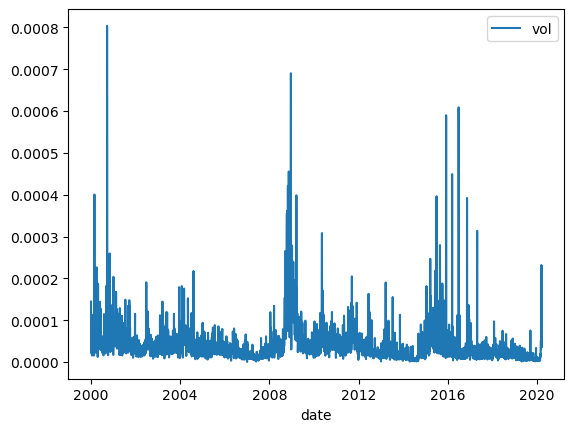

In [20]:
daily_vol_eurusd.plot()

In [21]:
from helper_functions.afml_functions.afml_modelling_lib import encode_and_entropy

In [222]:
daily_entropy_eurusd = eurusd_data[['date', 'ret']].groupby('date').apply(lambda x: encode_and_entropy(x['ret'], 10, 3)) #.rename({'ret': 'entropy'}, axis=1)

KeyError: "['ret'] not in index"

<Axes: xlabel='date'>

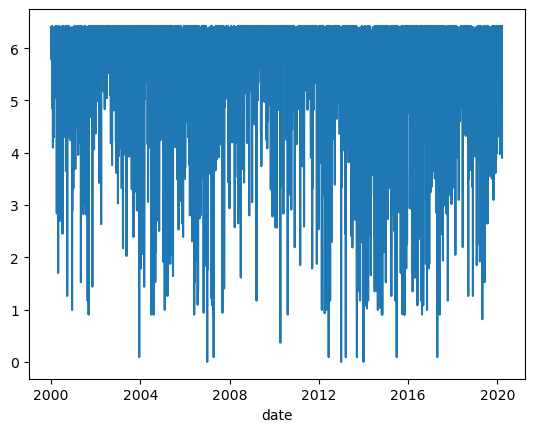

In [51]:
daily_entropy_eurusd.plot()

In [22]:
import statsmodels.api as sm

In [23]:
eurusd_data = eurusd_data.drop('DATE_TIME', axis=1)

In [24]:
eurusd_data

,CLOSE,date,ret,ret_sqd
0,1.00770,2000-01-03,NaN,NaN
1,1.00860,2000-01-03,0.000893,7.969568e-07
2,1.00790,2000-01-03,-0.000694,4.820140e-07
3,1.01280,2000-01-03,0.004850,2.352070e-05
4,1.01220,2000-01-03,-0.000593,3.511660e-07
...,...,...,...,...
500746,1.08895,2020-03-19,0.000854,7.299970e-07
500747,1.08872,2020-03-19,-0.000211,4.462020e-08
500748,1.09086,2020-03-19,0.001964,3.856046e-06
500749,1.08970,2020-03-19,-0.001064,1.131983e-06


In [27]:
eurusd_data_daily = eurusd_data.groupby('date').tail(1)
eurusd_data_daily['ret_bps'] = 1e4*np.log(eurusd_data_daily['CLOSE']/eurusd_data_daily['CLOSE'].shift())
eurusd_data_daily

C:\Users\camer\AppData\Local\Temp\ipykernel_62276\878831192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eurusd_data_daily['ret_bps'] = 1e4*np.log(eurusd_data_daily['CLOSE']/eurusd_data_daily['CLOSE'].shift())


,CLOSE,date,ret,ret_sqd,ret_bps
95,1.02460,2000-01-03,0.000488,2.382557e-07,NaN
189,1.02920,2000-01-04,0.000194,3.776981e-08,44.795089
285,1.03260,2000-01-05,0.000291,8.443149e-08,32.980920
381,1.03300,2000-01-06,0.000000,0.000000e+00,3.872967
477,1.02980,2000-01-07,-0.000097,9.428705e-09,-31.025815
...,...,...,...,...,...
500437,1.11023,2020-03-13,-0.000513,2.634516e-07,-57.659306
500533,1.11775,2020-03-16,-0.000018,3.201569e-10,67.505351
500629,1.10055,2020-03-17,0.000100,9.991006e-09,-155.076813
500725,1.09114,2020-03-18,0.000110,1.209621e-08,-85.870336


#### this low frequency data kinda seems worse
lets:
- re-look at how to calculate entropy
- re-look at how to calculate/estimate variance (just use r^2 or rolling value)
- then lets re-look at the estimators

In [28]:
from arch import arch_model

In [29]:
eurusd_data_daily

,CLOSE,date,ret,ret_sqd,ret_bps
95,1.02460,2000-01-03,0.000488,2.382557e-07,NaN
189,1.02920,2000-01-04,0.000194,3.776981e-08,44.795089
285,1.03260,2000-01-05,0.000291,8.443149e-08,32.980920
381,1.03300,2000-01-06,0.000000,0.000000e+00,3.872967
477,1.02980,2000-01-07,-0.000097,9.428705e-09,-31.025815
...,...,...,...,...,...
500437,1.11023,2020-03-13,-0.000513,2.634516e-07,-57.659306
500533,1.11775,2020-03-16,-0.000018,3.201569e-10,67.505351
500629,1.10055,2020-03-17,0.000100,9.991006e-09,-155.076813
500725,1.09114,2020-03-18,0.000110,1.209621e-08,-85.870336


In [252]:
eurusd_ret = eurusd_data_daily['ret_bps'].dropna()
eurusd_ret.index = pd.to_datetime(eurusd_ret.index)

In [253]:
from datetime import datetime

#index = eurusd_data_daily.index
#end_loc = np.where(index >= "2000-01-05")[0].min()

am = arch_model(eurusd_ret, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(last_obs="2001-01-04", update_freq=5) # fits up to last obs, then applies the forecasts to the observations as they come in (I don't think we are just doing a forecast using prev estimate, we should be using observation)
forecasts = res.forecast()
print(forecasts.variance.dropna().head())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1505.8666949613812
            Iterations: 4
            Function evaluations: 23
            Gradient evaluations: 4
                    h.1
date                   
2001-01-03  5903.531928
2001-01-04  5903.531929
2001-01-05  5903.531929
2001-01-08  5903.531929
2001-01-09  5903.531928


In [256]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_bps   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1505.87
Distribution:                  Normal   AIC:                           3019.73
Method:            Maximum Likelihood   BIC:                           3034.01
                                        No. Observations:                  262
Date:                Wed, Nov 20 2024   Df Residuals:                      261
Time:                        22:01:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -3.8135      4.883     -0.781      0.435 [-13.384,  5.757]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        578.0587    719.267      0.804      0.422 [-8.317e+02,1.988e+03]
alpha[1]   1.1930e-11  3.720e-02  3.207e-10      1.000 [-7.291e-02,7.291e-02]
beta[1]        0.9021      0.114      7.926  2.254e-15      [  0.679,  1.125]
=============================================================================

Covariance estimator: robust
"""

In [254]:
forecasts.variance

,h.1
date,
2001-01-03,5903.531928
2001-01-04,5903.531929
2001-01-05,5903.531929
2001-01-08,5903.531929
2001-01-09,5903.531928
...,...
2020-03-13,5903.531927
2020-03-16,5903.531927
2020-03-17,5903.531928


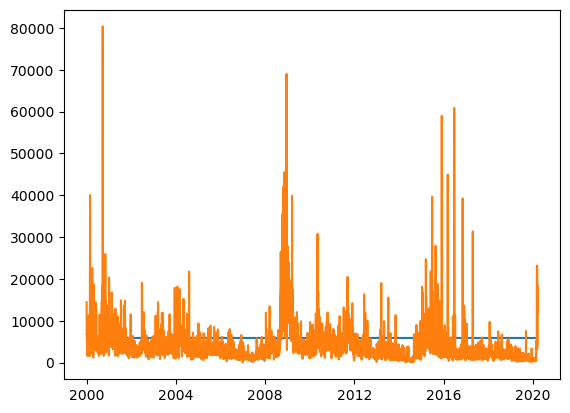

In [266]:
vol_by_garch = forecasts.variance
vol_by_daily_vol = daily_vol_eurusd
plt.plot(vol_by_garch, label='GARCH')
plt.plot(vol_by_daily_vol, label='Daily Vol')
plt.show()

garch model is just predicting the mean

In [269]:
index = eurusd_ret.index
start_loc = 0
end_loc = np.where(index >= "2001-1-1")[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

....................
                    h.1          h.2          h.3
2000-12-29  5691.048867  5691.048867  5691.048867
2001-01-01  5668.282795  5668.282795  5668.282795
2001-01-02  5688.429395  5688.429395  5688.429395
2001-01-03  5903.531928  5903.531928  5903.531928
2001-01-04  7954.060162  7784.475421  7631.300313
2001-01-05  7471.577137  7346.179806  7232.952048
2001-01-08  7626.643537  7488.384262  7363.535098
2001-01-09  7040.744244  6955.057401  6877.709832
2001-01-10  6877.610269  6806.828914  6742.943833
2001-01-11  7807.455949  7658.023064  7523.074946
2001-01-12  7252.692941  7152.483811  7062.019871
2001-01-15  7187.999726  7094.409344  7009.925163
2001-01-16  6834.934449  6771.958186  6715.123417
2001-01-17  6684.437258  6634.623488  6589.672436
2001-01-18  6586.621497  6545.457612  6508.315172
2001-01-19  6569.511264  6530.472710  6495.248369
2001-01-22  6439.547603  6411.246781  6385.713904
2001-01-23  6319.097584  6300.338140  6283.415131
2001-01-24  6406.117811  6381

In [272]:
forecasts.T.variance

AttributeError: 'dict' object has no attribute 'T'

#### Later:
- look at garch model volatility and see if it predicts volatility correctly --> note that with garch we get a prediction of vol for every time point so be careful with this, look at how other papers have handled volatility. Thinking about what the book was saying, I think we'd just need to use daily returns here to estimate the volatility, not the fine grain stuff (the finer grain vol provides the better estimate by just using the estimators, this is why the book suggested we needed to use fine grain volatility).
- compare garch model to entropy predicted model --> still take a look at the ratio of sequence length to total length and q etc for entropy estimation; might be better to look at higher frequency data for this reason (we could still do daily returns but with 1 minute time points)
- look at combining the two, should probably make garch/prev day volatility the benchmark
- Form a solid univariate model connecting entropy estimation to volatility
- Perhaps then look at multivariate, bring in mutual entropy/information and see if we can predict the entire covariance matrix

In [30]:
# lets just make ou benchmark model a model that predicts intraday volatility using previous intraday volatility (ie an AR(1) model)
import statsmodels.api as sm

future_vol = daily_vol_eurusd
today_vol = daily_vol_eurusd.shift().dropna()
future_vol = future_vol.loc[today_vol.index]
X = sm.add_constant(today_vol)
model = sm.OLS(future_vol['vol'], X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     2446.
Date:                Sun, 24 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:51:40   Log-Likelihood:                 46500.
No. Observations:                5254   AIC:                        -9.300e+04
Df Residuals:                    5252   BIC:                        -9.298e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.7e-05   6.53e-07     26.043      0.000    1.57e-05    1.83e-05
vol            0.5633      0.011     49.455      0.000       0.541       0.586
==============================================================================
Omnibus:                     6360.599   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1961654.933
Skew:                           6.112   Prob(JB):                         0.00
Kurtosis:                      96.868   Cond. No.                     2.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
np.isinf(future_vol).values.sum()

0

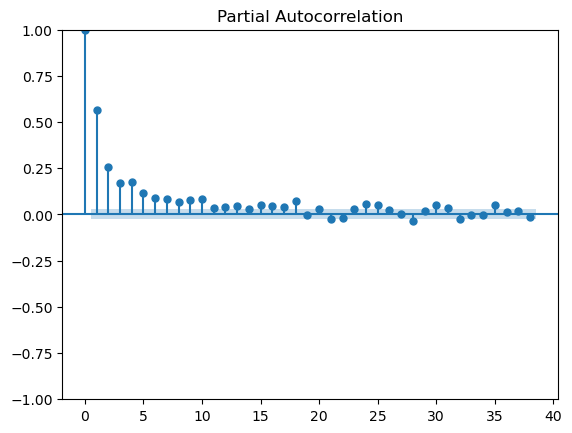

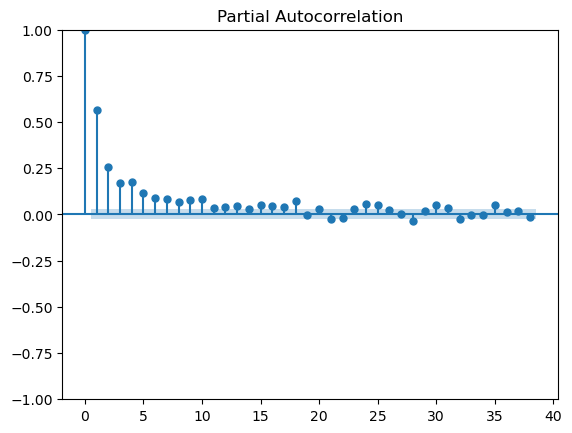

In [32]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(future_vol)

In [64]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

ModuleNotFoundError: No module named 'statsmodels.api.tsa'; 'statsmodels.api' is not a package

- set a benchmark based omn AR model
- find somehighe frequency dfaat
- regress with entropy
- midas with entropy - check residuals etc in ols and midas
- nonlinar models

In [35]:
adfuller(future_vol)

(-4.714719213328281,
 7.895512875792945e-05,
 31,
 5222,
 {'1%': -3.431602875792823,
  '5%': -2.862093640802141,
  '10%': -2.567064702779875},
 -93411.96223789119)

Indicates TS is at least stationary

array([[<Axes: title={'center': 'vol'}>]], dtype=object)

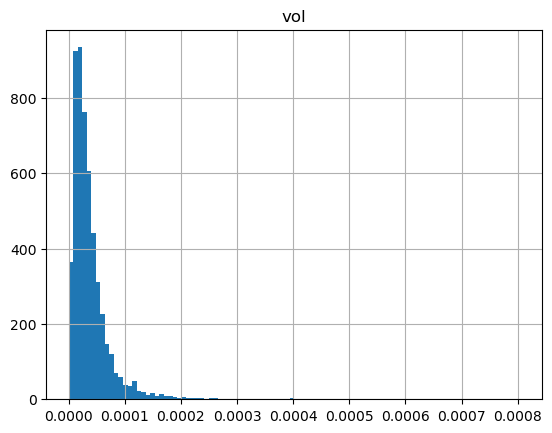

In [36]:
future_vol.hist(bins=100)

Distribution is skewed (right skewed) so extreme positive events are likely - lets do a long transform on this

In [68]:
log_future_vol = pd.DataFrame(np.log(future_vol))

Much better

In [78]:
arma_model1 = ARIMA(log_future_vol, order=(2, 0, 1))
res1 = arma_model1.fit()
res1.summary()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    vol   No. Observations:                 5254
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -3729.314
Date:                Sun, 24 Nov 2024   AIC                           7468.629
Time:                        23:14:30   BIC                           7501.462
Sample:                             0   HQIC                          7480.107
                               - 5254                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4529      0.147    -71.259      0.000     -10.740     -10.165
ar.L1          1.1207      0.016     69.423      0.000       1.089       1.152
ar.L2         -0.1277      0.016     -8.129      0.000      -0.158      -0.097
ma.L1         -0.8508      0.009    -93.435      0.000      -0.869      -0.833
sigma2         0.2420      0.003     79.251      0.000       0.236       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2199.99
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
arma_model2 = ARIMA(log_future_vol, order=(1, 0, 1))
res2 = arma_model2.fit()
res2.summary()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    vol   No. Observations:                 5254
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3754.254
Date:                Sun, 24 Nov 2024   AIC                           7516.509
Time:                        11:52:20   BIC                           7542.776
Sample:                             0   HQIC                          7525.692
                               - 5254                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4587      0.124    -84.453      0.000     -10.701     -10.216
ar.L1          0.9882      0.002    430.896      0.000       0.984       0.993
ma.L1         -0.7902      0.009    -92.388      0.000      -0.807      -0.773
sigma2         0.2444      0.003     78.597      0.000       0.238       0.250
===================================================================================
Ljung-Box (L1) (Q):                  27.34   Jarque-Bera (JB):              2091.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
res2.forecast()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


5254   -9.521388
dtype: float64

In [40]:
log_future_vol

,vol
date,
2000-01-04,-9.619532
2000-01-05,-9.593818
2000-01-06,-9.826425
2000-01-07,-9.812373
2000-01-10,-10.441778
...,...
2020-03-13,-9.055258
2020-03-16,-8.599058
2020-03-17,-9.449374


Based om AIC/BIC cirterions, pick the ARMA(2, 1) model

In [41]:
res2.predict()

date
2000-01-04   -10.458747
2000-01-05    -9.877182
2000-01-06    -9.764956
2000-01-07    -9.792546
2000-01-10    -9.805648
                ...    
2020-03-13    -9.594473
2020-03-16    -9.497856
2020-03-17    -9.331165
2020-03-18    -9.367843
2020-03-19    -9.330924
Name: predicted_mean, Length: 5254, dtype: float64

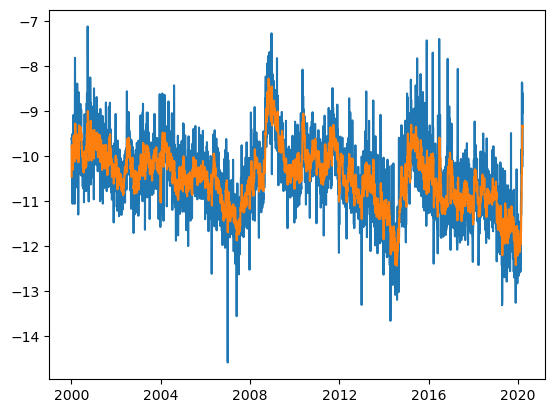

In [42]:
plt.plot(log_future_vol, label='actual')
plt.plot(res2.predict(), label='prediction')

In [74]:
log_future_vol_train

,vol
date,
2000-01-04,-9.619532
2000-01-05,-9.593818
2000-01-06,-9.826425
2000-01-07,-9.812373
2000-01-10,-10.441778
...,...
2019-03-21,-11.313864
2019-03-22,-10.141469
2019-03-25,-11.560825


In [103]:
log_future_vol_test #.dropna()

,vol
5000,-11.056440
5001,-11.610383
5002,-11.969470
5003,-12.097270
5004,-11.666269
...,...
5249,-9.055258
5250,-8.599058
5251,-9.449374
5252,-9.116603


In [81]:
log_future_train_intind = log_future_vol.reset_index(drop=True)
log_future_vol_train = log_future_train_intind.iloc[:5000]
log_future_vol_test = log_future_train_intind.iloc[5000:]

arma_model = ARIMA(log_future_vol_train, order=(2, 0, 1))
res = arma_model.fit()
print(res.summary())

res= res.extend(log_future_vol_test)

res.predict()

                               SARIMAX Results                                
Dep. Variable:                    vol   No. Observations:                 5000
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -3502.811
Date:                Sun, 24 Nov 2024   AIC                           7015.622
Time:                        23:16:18   BIC                           7048.208
Sample:                             0   HQIC                          7027.043
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4352      0.142    -73.596      0.000     -10.713     -10.157
ar.L1          1.1287      0.016     69.403      0.000       1.097       1.161
ar.L2         -0.1351      0.016     -8.545      0.0

5000   -11.200564
5001   -11.197105
5002   -11.319419
5003   -11.444623
5004   -11.538085
          ...    
5249    -9.719269
5250    -9.731126
5251    -9.530521
5252    -9.641022
5253    -9.534717
Name: predicted_mean, Length: 254, dtype: float64

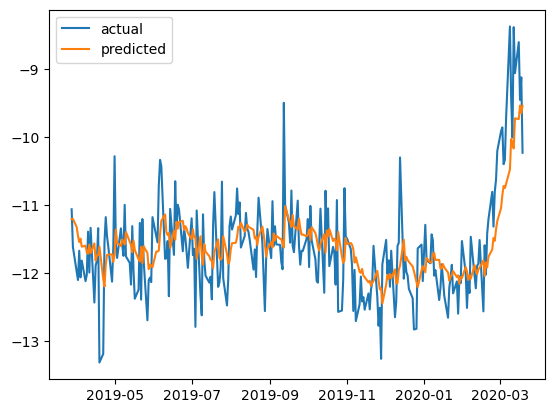

In [86]:
predicted = res.predict()
predicted.index = log_future_vol.iloc[5000:].index
actual = log_future_vol.iloc[5000:]

plt.plot(actual, label='actual')
plt.plot(predicted, label='predicted')
plt.legend()
plt.show()

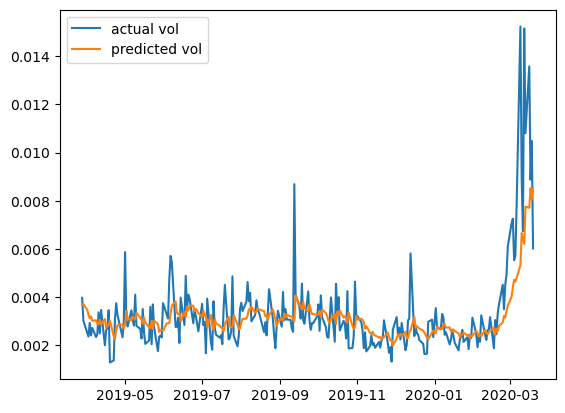

In [93]:
# transform back to std and find mse
def vol_inverse_transform(log_var):
    return np.sqrt(np.exp(log_var))

actual_vol = vol_inverse_transform(actual)
predicted_vol = vol_inverse_transform(predicted)
plt.plot(actual_vol, label='actual vol')
plt.plot(predicted_vol, label='predicted vol')
plt.legend()
plt.show()

In [111]:
mse = np.mean((actual_vol['vol'] - predicted_vol)**2)
mse

1.7882246101499534e-06

In [112]:
import itertools
best_rsqd = 0
best_qL = (2, 10)
for q, L in itertools.product([9, 10, 11], [14, 15, 16]):
    entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()
    mod = sm.OLS(eurusd_data[['date', 'ret_sqd']].set_index('date').groupby('date').mean().iloc[1:], entropy_prev_day.dropna())
    res = mod.fit()
    print(q, L, res.rsquared)
    best_rsqd = max(res.rsquared, best_rsqd)
    if res.rsquared == best_rsqd:
        best_qL = (q, L)
print(best_qL, best_rsqd)

C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


9 14 0.4617601460835684


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


9 15 0.4617245026330411


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


9 16 0.4616948983285756


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


10 14 0.4615159218790462


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


10 15 0.46148929273745165


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


10 16 0.46146859255463923


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


11 14 0.4616137659222499


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


11 15 0.4615764429988596
11 16 0.4615365561130784
(9, 14) 0.4617601460835684


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


In [116]:
L = 14 # length of the pattern
q = 3 # despite tests above, 9 will like be too much, lets just stick with 3 for now
entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()

C:\Users\camer\AppData\Local\Temp\ipykernel_62276\660271669.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


In [117]:
entropy_prev_day

date
2000-01-03         NaN
2000-01-04    6.191702
2000-01-05    6.321928
2000-01-06    6.357552
2000-01-07    6.333162
                ...   
2020-03-13    5.928049
2020-03-16    6.285402
2020-03-17    6.357552
2020-03-18    6.357552
2020-03-19    5.960853
Length: 5255, dtype: float64

In [123]:
entropy_prev_day = pd.DataFrame(entropy_prev_day, columns=['entropy'])
entropy_prev_day_intind = entropy_prev_day.reset_index(drop=True)

entropy_prev_day_train = entropy_prev_day_intind.iloc[:5000]
entropy_prev_day_test = entropy_prev_day_intind.iloc[5000:]

arma_entropy_model = ARIMA(log_future_vol_train.iloc[1:], exog=entropy_prev_day_train.dropna(), order=(1, 0, 1))
res_entropy = arma_entropy_model.fit()
print(res_entropy.summary())

res_entropy = res_entropy.extend(log_future_vol_test, exog=entropy_prev_day_test)

res_entropy.predict()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    vol   No. Observations:                 4999
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3527.085
Date:                Tue, 26 Nov 2024   AIC                           7064.170
Time:                        22:59:31   BIC                           7096.755
Sample:                             0   HQIC                          7075.591
                               - 4999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5361      0.123    -85.848      0.000     -10.777     -10.296
entropy        0.0174      0.007      2.414      0.016       0.003       0.031
ar.L1          0.9878      0.002    406.851      0.0

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Given `endog` does not have an index that extends the index of the model.

In [ ]:
# WHY DOES THIS NEVER SEEM TO WORK!!!

In [124]:
entropy_prev_day_train.dropna()

,entropy
1,6.191702
2,6.321928
3,6.357552
4,6.333162
5,6.308772
...,...
4995,6.357552
4996,2.718249
4997,6.357552
4998,2.732572


In [125]:
entropy_prev_day_test

,entropy
5000,6.009633
5001,6.357552
5002,6.308772
5003,6.285402
5004,6.076826
...,...
5250,5.928049
5251,6.285402
5252,6.357552
5253,6.357552


Using exog appears to be worse for the AIC/BIC even when we take out the AR2 parameter, lets see how it performs out of sample